# BERT Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install

In [ ]:
!pip install transformers
# !pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 29.8 MB/s 
     |████████████████████████████████| 101 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
from transformers import BertModel, BertTokenizer

In [ ]:
# train_path = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/tu_sua_tay_data_train.csv'
# test_path = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/tu_sua_tay_data_test.csv'

In [ ]:
data_embedding = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/processed_data_deleted.csv")
data_embedding.head()

Unnamed: 0                                            comment  rating
0           4  màu xanh ở ngoài nhìn đẹp sang thích hợp cho n...       1
1           8  đóng gói cẩn thận giao đúng lúc giờ đúng sản p...       1
2           9  hộp bên ngoài hộp giấy tiki á hơi bị móp xíu b...       1
3          13  rất tốt nha và coi để độ bền nhưng thấy máy rấ...       1
4          16  hang giao con niem phong nhưng su dung duc thô...       1

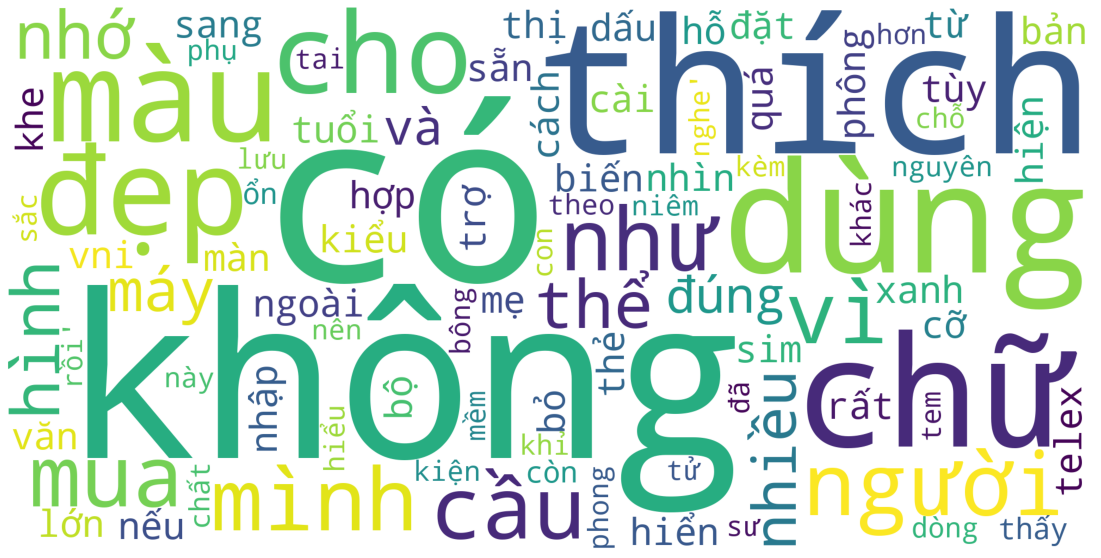

In [ ]:
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
cloud = np.array(data_embedding).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(max_words=1000,background_color ="White",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [ ]:
from google.colab import data_table
data_table.DataTable(data_embedding, include_index=False, num_rows_per_page=10)

# Embedding

In [ ]:
# data_copy_ = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/train_lazada_copy.csv")
# data_embedding_clean = data_prep.copy()
# data_embedding_clean.head()

In [ ]:
from pyvi.ViTokenizer import tokenize

data_embedding['comment'] = data_embedding['comment'].apply(lambda x: tokenize(str(x)))
data_embedding.drop("Unnamed: 0", inplace=True, axis=1)
data_embedding.head()

comment  rating
0  mình cho sao vì thái_độ dịch_vụ khách_hàng tại...      -1
1  sản_phẩm tầm giá nhìn cũng đx mình mua cho pa ...       0
2  màu xanh ở ngoài nhìn đẹp sang thích_hợp cho n...       1
3  sản_phẩm mình mua được giao nhanh nhận hàng kh...      -1
4  đóng_gói cẩn_thận giao đúng lúc giờ đúng sản_p...       1

In [ ]:
data_embedding['rating'].value_counts()

 1    10942
-1     2676
 0     1435
Name: rating, dtype: int64

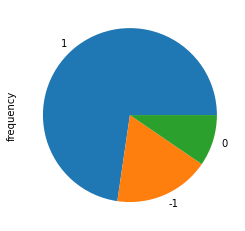

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
data_embedding['rating'].value_counts().plot(ax = ax, kind = 'pie', ylabel = 'frequency')
plt.show()

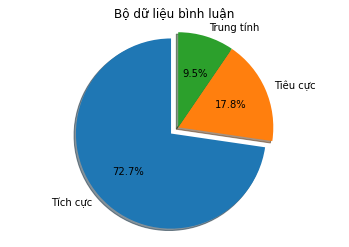

In [ ]:
data = [10942, 2676, 1435]
label = ['Tích cực', 'Tiêu cực', 'Trung tính']
 
plt.pie(data, labels=label, autopct='%1.1f%%', explode=[0.1, 0, 0], shadow=True, startangle=90)
plt.title('Bộ dữ liệu bình luận')
plt.axis('equal')
plt.show()

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")


Downloading:   0%|          | 0.00/270 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at VoVanPhuc/sup-SimCSE-VietNamese-phobert-base were not used when initializing RobertaModel: ['mlp.dense.bias', 'mlp.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def extract_features(s):
  vector = ""
  inputs = PhobertTokenizer(s, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
      doc = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
  return doc[0].numpy()
  
def convert_to_array(data_frame, col):
  return np.array(data_frame[col].tolist())

from tqdm import tqdm
tqdm.pandas()

def vector_column(data_frame, col1, col2):
  data_frame[col2] = data_frame[col1].progress_apply(lambda x: np.array(extract_features(x))) 
  return data_frame

In [ ]:
data_embedding_ = vector_column(data_embedding, 'comment', 'vector')

100%|██████████| 15053/15053 [25:24<00:00,  9.88it/s]


In [ ]:
data_embedding_.to_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/data_embedding_full.csv')

In [ ]:
X_data = convert_to_array(data_embedding_, 'vector')
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/phobert_embedding_3class_full.npy', X_data, allow_pickle=True)

In [ ]:
X_data = convert_to_array(data_embedding_, 'vector')

# Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import seaborn as sns

In [ ]:
X_data = np.load('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/phobert_embedding_3class_full.npy', allow_pickle=True)

In [ ]:
data_embedding_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/data_embedding_full.csv')

In [ ]:
data_embedding_.drop("Unnamed: 0", inplace = True, axis = 1)
data_embedding_.head()

comment  rating  \
0  mình cho sao vì thái_độ dịch_vụ khách_hàng tại...       0   
1  sản_phẩm tầm giá nhìn cũng đx mình mua cho pa ...       1   
2  màu xanh ở ngoài nhìn đẹp sang thích_hợp cho n...       2   
3  sản_phẩm mình mua được giao nhanh nhận hàng kh...       0   
4  đóng_gói cẩn_thận giao đúng lúc giờ đúng sản_p...       2   

                                              vector  
0  [ 0.00061139  0.305091   -0.2689877   0.081543...  
1  [-1.07739285e-01  3.53386641e-01  3.06639988e-...  
2  [-0.06105313  0.32824582  0.11574502 -0.064779...  
3  [-2.87095308e-01  4.71708030e-01 -2.44699970e-...  
4  [-1.62013128e-01  3.46394032e-01 -3.22780609e-...

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_embedding_['rating'] = le.fit_transform(data_embedding_['rating'].astype(str))

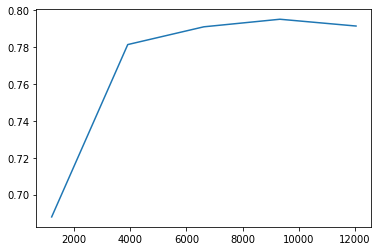

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

X, y = X_data, data_embedding_['rating']
estimator = SVC(gamma=0.001)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=5,return_times=True)

plt.plot(train_sizes,np.mean(train_scores,axis=1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

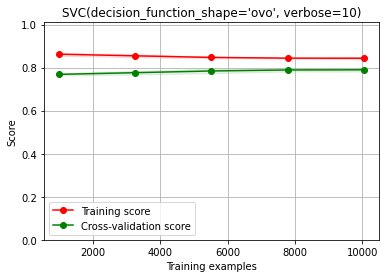

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

!pip install lightgbm

from lightgbm import LGBMRegressor

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from sklearn.svm import SVC

svc_model = SVC(decision_function_shape = 'ovo', verbose=10)
# lgb = LGBMRegressor(min_data=1,random_state=5, n_jobs=1)
std = StandardScaler()
x = X_data
y = data_embedding_['rating']

title = svc_model
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
plt = plot_learning_curve(svc_model, title, x, y, cv=3, ylim=(0.0, 1.01), n_jobs=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search fail

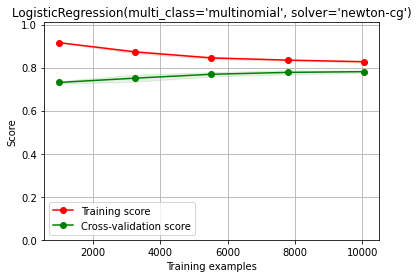

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
title = lr_model
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
plt = plot_learning_curve(lr_model, title, x, y, cv=3, ylim=(0.0, 1.01), n_jobs=1)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
x_train, x_test, y_train, y_test = train_test_split(X_data, data_embedding_['rating'], test_size=0.1, shuffle=False) 

# Logistic Regression

{'Tiêu cực': {'precision': 0.6115384615384616, 'recall': 0.6625, 'f1-score': 0.636, 'support': 240}, 'Trung tính': {'precision': 0.35294117647058826, 'recall': 0.09022556390977443, 'f1-score': 0.1437125748502994, 'support': 133}, 'Tích cực': {'precision': 0.8613861386138614, 'recall': 0.9214474845542807, 'f1-score': 0.890405117270789, 'support': 1133}, 'accuracy': 0.8067729083665338, 'macro avg': {'precision': 0.6086219255409704, 'recall': 0.5580576828213517, 'f1-score': 0.5567058973736961, 'support': 1506}, 'weighted avg': {'precision': 0.7766672657963639, 'recall': 0.8067729083665338, 'f1-score': 0.7839195022064368, 'support': 1506}}


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


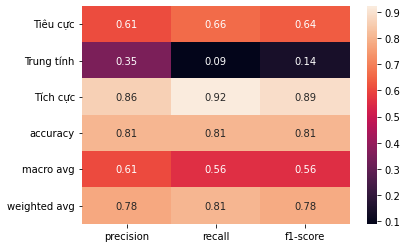

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(x_train, y_train)

y_predict = lr_model.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# SVM

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Tiêu cực': {'precision': 0.5849802371541502, 'recall': 0.6166666666666667, 'f1-score': 0.6004056795131846, 'support': 240}, 'Trung tính': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 133}, 'Tích cực': {'precision': 0.8531524341580208, 'recall': 0.9435127978817299, 'f1-score': 0.8960603520536463, 'support': 1133}, 'accuracy': 0.8081009296148738, 'macro avg': {'precision': 0.479377557104057, 'recall': 0.5200598215161322, 'f1-score': 0.4988220105222769, 'support': 1506}, 'weighted avg': {'precision': 0.7350710257755867, 'recall': 0.8081009296148738, 'f1-score': 0.7698099216201498, 'support': 1506}}


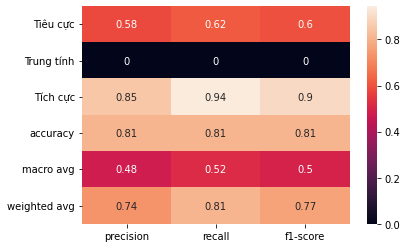

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(decision_function_shape = 'ovo', verbose=10)
# , class_weight = {0:3, 1:0, 2:5}
svc_model.fit(x_train, y_train)

y_predict = svc_model.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

[LibSVM]{'Tiêu cực': {'precision': 0.5677966101694916, 'recall': 0.5491803278688525, 'f1-score': 0.5583333333333333, 'support': 488}, 'Trung tính': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 289}, 'Tích cực': {'precision': 0.8267034265458842, 'recall': 0.9395702775290958, 'f1-score': 0.8795306934841819, 'support': 2234}, 'accuracy': 0.7861175689139821, 'macro avg': {'precision': 0.46483334557179196, 'recall': 0.49625020179931606, 'f1-score': 0.47928800893917173, 'support': 3011}, 'weighted avg': {'precision': 0.7053936236021977, 'recall': 0.7861175689139821, 'f1-score': 0.7430548774195712, 'support': 3011}}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


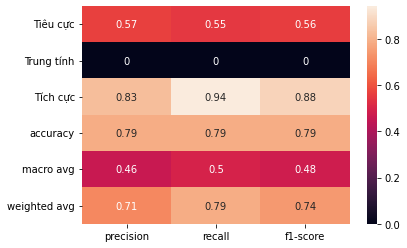

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
svc_model = SVC(decision_function_shape = 'ovo', verbose=10)
# , class_weight = {0:3, 1:0, 2:5}
svc_model.fit(x_train, y_train)

y_predict = svc_model.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# Random Forest

{'Tiêu cực': {'precision': 0.5700934579439252, 'recall': 0.5083333333333333, 'f1-score': 0.5374449339207048, 'support': 240}, 'Trung tính': {'precision': 0.5, 'recall': 0.007518796992481203, 'f1-score': 0.014814814814814812, 'support': 133}, 'Tích cực': {'precision': 0.8286821705426357, 'recall': 0.9435127978817299, 'f1-score': 0.8823772183243912, 'support': 1133}, 'accuracy': 0.7915006640106241, 'macro avg': {'precision': 0.6329252094955203, 'recall': 0.4864549760691815, 'f1-score': 0.47821232235330363, 'support': 1506}, 'weighted avg': {'precision': 0.7584457696755301, 'recall': 0.7915006640106241, 'f1-score': 0.7507905331161188, 'support': 1506}}


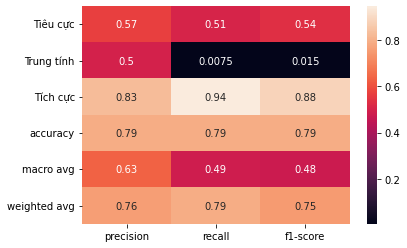

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=None, random_state=0)
rfc.fit(x_train, y_train)

y_predict = rfc.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'Tiêu cực': {'precision': 0.5377777777777778, 'recall': 0.4745098039215686, 'f1-score': 0.5041666666666667, 'support': 255}, 'Trung tính': {'precision': 0.19444444444444445, 'recall': 0.05737704918032787, 'f1-score': 0.08860759493670886, 'support': 122}, 'Tích cực': {'precision': 0.8369477911646587, 'recall': 0.9229406554472985, 'f1-score': 0.8778433024431339, 'support': 1129}, 'accuracy': 0.7768924302788844, 'macro avg': {'precision': 0.5230566711289603, 'recall': 0.48494250284973167, 'f1-score': 0.49020585468216976, 'support': 1506}, 'weighted avg': {'precision': 0.734242770106544, 'recall': 0.7768924302788844, 'f1-score': 0.7506359329618703, 'support': 1506}}


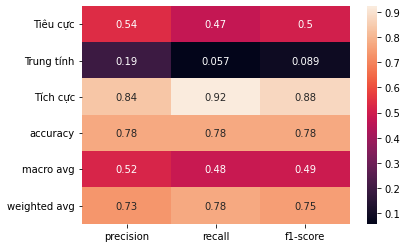

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test)

params = {
    'max_depth': 100,
    'objective': 'multi:softmax',  
    'num_class': 3,
    'n_gpus': 0,
    'learning_rate': 0.5,
    'n_estimators': 100,
    'eta':0.1,
    'subsample':0.8
}
# num_round = 2

# cv_analysis = xgb.cv(params, dtrain, num_round, nfold=5, seed=0)

bst = xgb.train(params, dtrain)

y_predict = bst.predict(dtest)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# LightGBM

{'Tiêu cực': {'precision': 0.5813953488372093, 'recall': 0.625, 'f1-score': 0.6024096385542168, 'support': 240}, 'Trung tính': {'precision': 0.3333333333333333, 'recall': 0.045112781954887216, 'f1-score': 0.07947019867549669, 'support': 133}, 'Tích cực': {'precision': 0.8577235772357723, 'recall': 0.9311562224183584, 'f1-score': 0.8929327126534067, 'support': 1133}, 'accuracy': 0.8041168658698539, 'macro avg': {'precision': 0.590817419802105, 'recall': 0.5337563347910819, 'f1-score': 0.5249375166277067, 'support': 1506}, 'weighted avg': {'precision': 0.7673765139856531, 'recall': 0.8041168658698539, 'f1-score': 0.7747945638201612, 'support': 1506}}


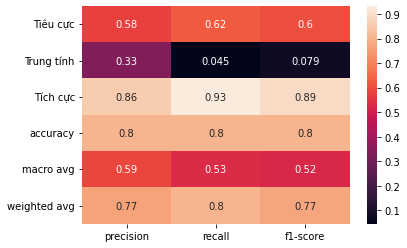

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

model_ltb = lgb.LGBMClassifier()
model_ltb.fit(x_train, y_train)
y_predict = model_ltb.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# KFold

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
plt.style.use('ggplot')

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('LGBM', LGBMClassifier()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X_data, data_embedding_['rating'], test_size=0.2, shuffle=True) 
for name, model in models:
      kfold = model_selection.KFold(n_splits=5, random_state=None)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.785917 (0.006031)
SVM: 0.797874 (0.003211)
LGBM: 0.784172 (0.005277)


# So sánh 3 thuật toán tốt nhất

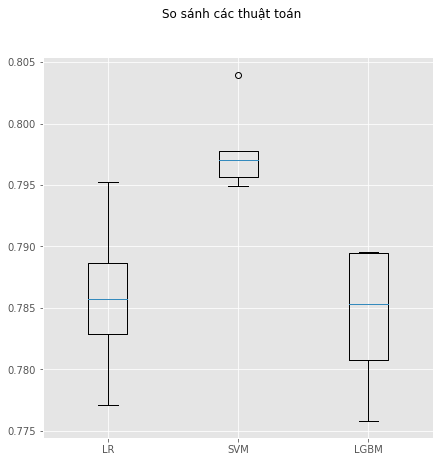

In [ ]:
fig = plt.figure(figsize=(7,7))
fig.suptitle('So sánh các thuật toán')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# LGBM K-Fold

In [ ]:
name = 'LGBM'
scoring = 'accuracy'
results = []
X_train, X_test, y_train, y_test = train_test_split(X_data, data_embedding_['rating'], test_size=0.2, shuffle=True) 
kfold = model_selection.KFold(n_splits=10, random_state=None)
cv_results = model_selection.cross_val_score(model_ltb, X_train, y_train, cv=kfold, scoring=scoring)
results.append(cv_results)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

LGBM: 0.789819 (0.008945)
